In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.7 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import optuna

In [ ]:
# Provide the correct paths to your CSV files
teddy_path = '/content/Teddy.csv'

# Load the datasets into DataFrames
teddy_df = pd.read_csv(teddy_path)

## EDA PLOTS FOR TEDDY DATASET

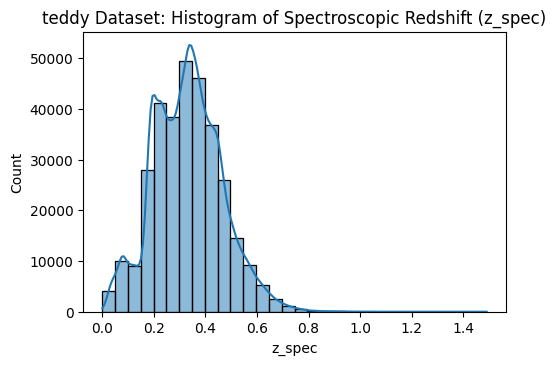

<Figure size 800x600 with 0 Axes>

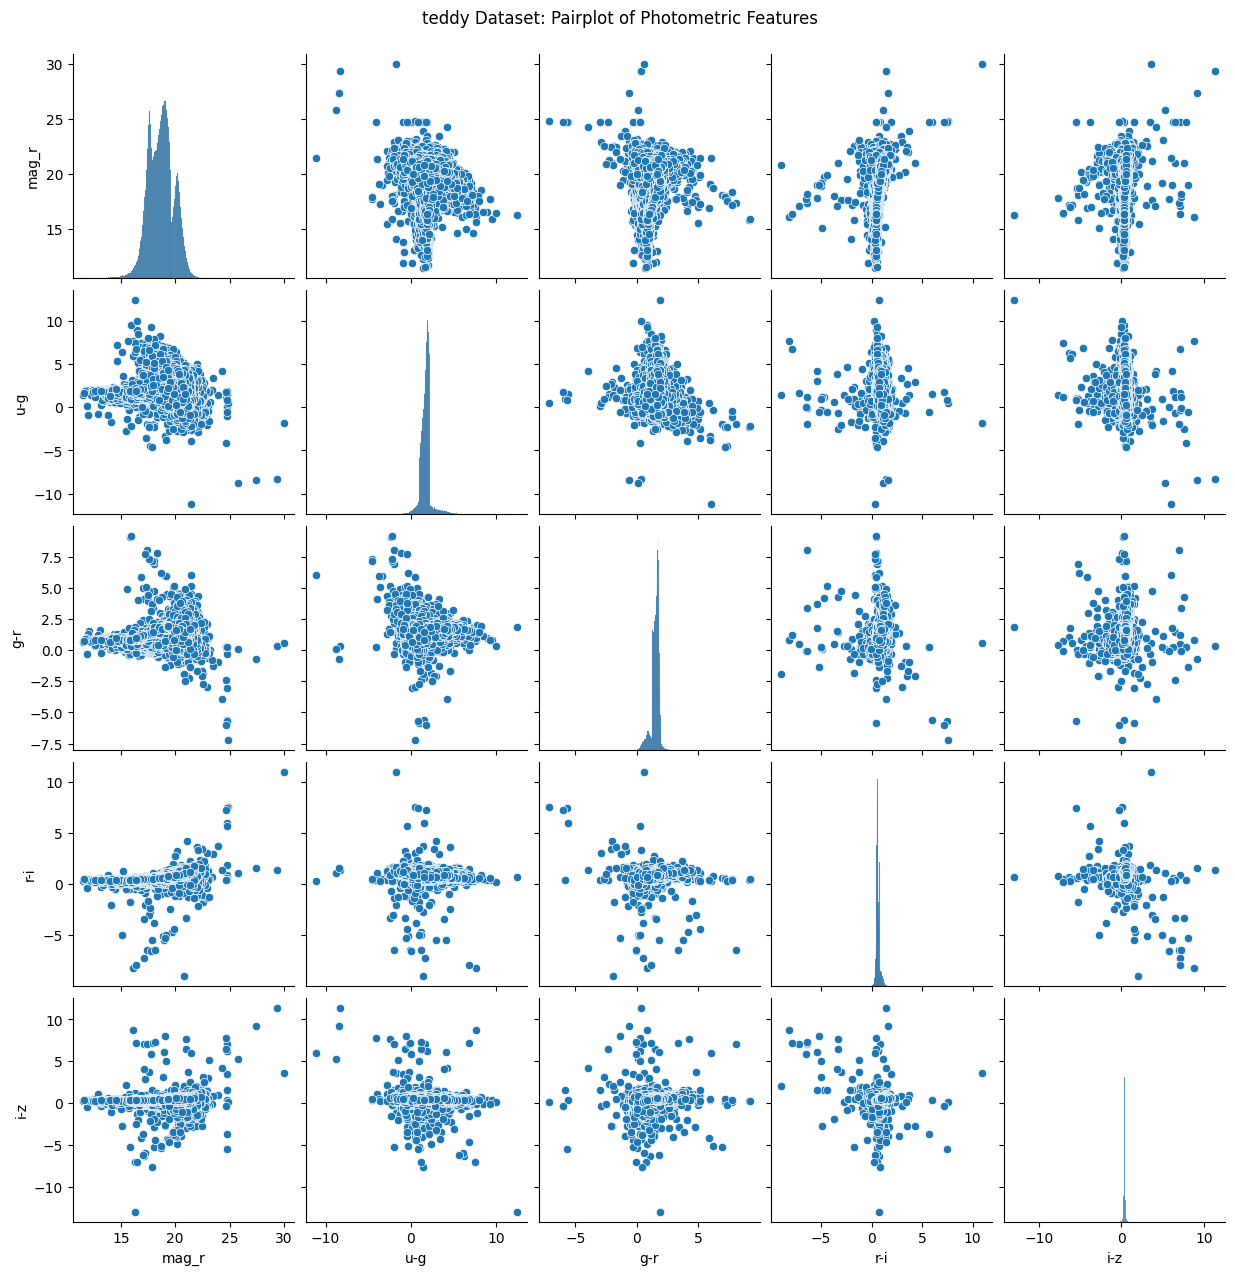

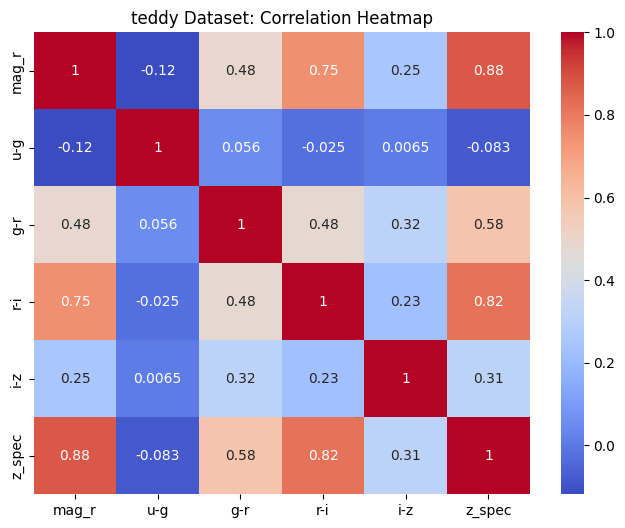

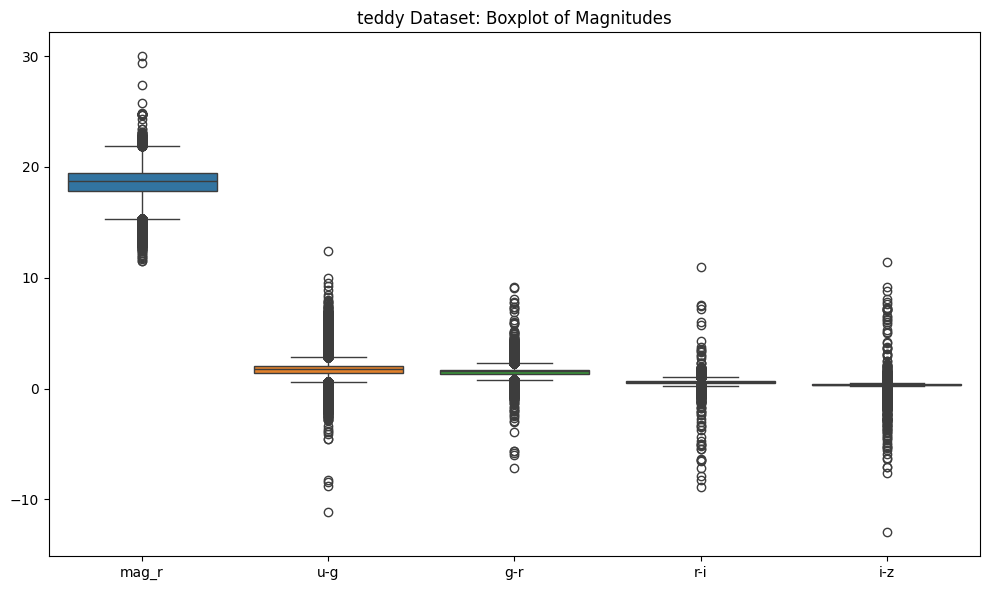

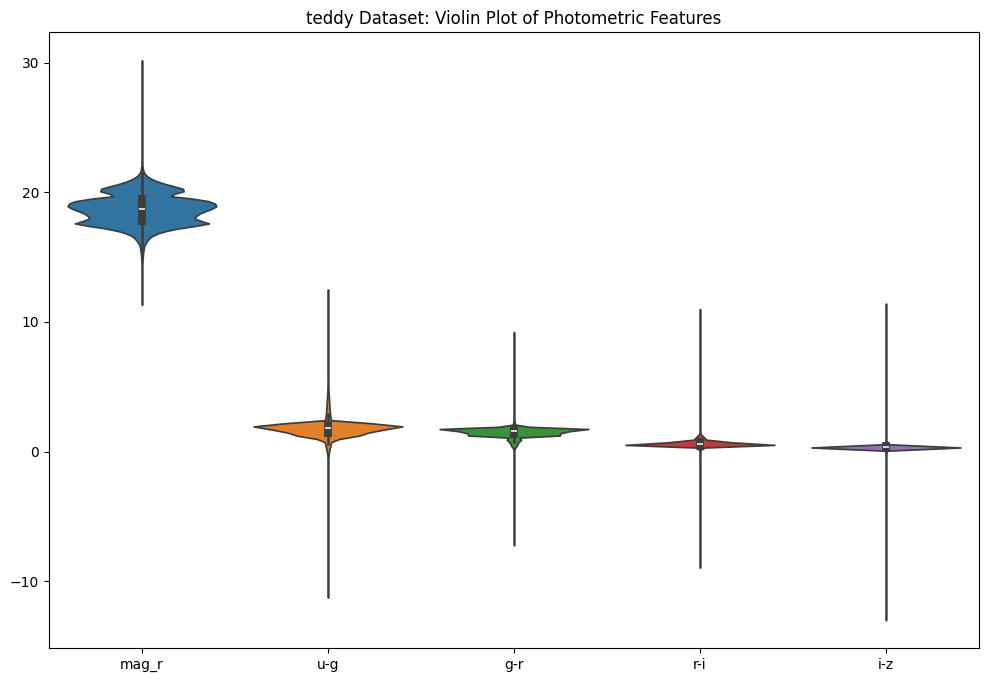

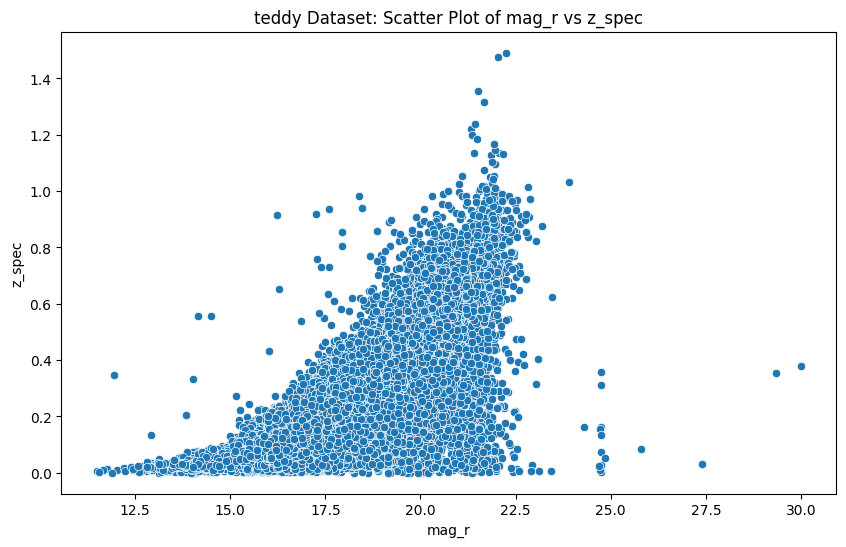

In [ ]:
# Function to create EDA plots
def create_eda_plots(df, dataset_name):
    plt.figure(figsize=(12, 8))

    # Histogram of spectroscopic redshift (z_spec)
    plt.subplot(2, 2, 1)
    sns.histplot(df['z_spec'], bins=30, kde=True)
    plt.title(f'{dataset_name}: Histogram of Spectroscopic Redshift (z_spec)')

    # Pairplot of photometric features
    plt.figure(figsize=(8, 6))
    sns.pairplot(df[['mag_r', 'u-g', 'g-r', 'r-i', 'i-z']])
    plt.suptitle(f'{dataset_name}: Pairplot of Photometric Features', y=1.02)

    # Correlation heatmap
    plt.figure(figsize=(8, 6))
    corr_matrix = df[['mag_r', 'u-g', 'g-r', 'r-i', 'i-z', 'z_spec']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title(f'{dataset_name}: Correlation Heatmap')

    # Boxplot of magnitudes
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df[['mag_r', 'u-g', 'g-r', 'r-i', 'i-z']])
    plt.title(f'{dataset_name}: Boxplot of Magnitudes')

    plt.tight_layout()
    plt.show()

     # Violin plot
    plt.figure(figsize=(12, 8))
    sns.violinplot(data=df[['mag_r', 'u-g', 'g-r', 'r-i', 'i-z']])
    plt.title(f'{dataset_name}: Violin Plot of Photometric Features')
    plt.show()

    # Count plot of 'u-g'
   # plt.figure(figsize=(10, 6))
    #sns.countplot(x='u-g', data=df)
    #plt.title(f'{dataset_name}: Count Plot of u-g')
    #plt.show()

    # Scatter plot of 'mag_r' vs 'z_spec'
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='mag_r', y='z_spec', data=df)
    plt.title(f'{dataset_name}: Scatter Plot of mag_r vs z_spec')
    plt.show()

# Create EDA plots for each dataset
create_eda_plots(teddy_df, 'teddy Dataset')



In [ ]:
# Load the dataset
df = pd.read_csv('/content/Teddy.csv')

# Define feature columns and target column (using normalized features)
features = ['feat1', 'feat2', 'feat3', 'feat4', 'feat5']
target = 'z_spec'

# Handle missing values
df = df.dropna(subset=features + [target])

X = df[features]
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
# Define the objective function for Optuna
def objective(trial):
    model_type = trial.suggest_categorical('model_type', ['RandomForest', 'GradientBoosting'])
    if model_type == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 10, 50)
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42
        )
    else:
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 10, 50)
        model = GradientBoostingRegressor(
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42
        )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

In [ ]:
# Create a study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print(f'Best hyperparameters: {best_params}')

# Train and evaluate the best model
if best_params['model_type'] == 'RandomForest':
    best_model = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        random_state=42
    )
else:
    best_model = GradientBoostingRegressor(
        learning_rate=best_params['learning_rate'],
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        random_state=42
    )

best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = best_model.score(X_train, y_train)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = best_model.score(X_test, y_test)

print(f'Training MSE: {mse_train}')
print(f'Training RMSE: {rmse_train}')
print(f'Training R²: {r2_train}')
print(f'Test MSE: {mse_test}')
print(f'Test RMSE: {rmse_test}')
print(f'Test R²: {r2_test}')

[I 2024-08-21 04:49:56,978] A new study created in memory with name: no-name-c9f09b58-3cfa-43a1-bffd-9562939a1102
[I 2024-08-21 05:05:42,942] Trial 0 finished with value: 0.0016330101051884576 and parameters: {'model_type': 'RandomForest', 'n_estimators': 265, 'max_depth': 29}. Best is trial 0 with value: 0.0016330101051884576.
<ipython-input-6-d6b3b85edc73>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
[I 2024-08-21 05:26:26,398] Trial 1 finished with value: 0.0026898856617299017 and parameters: {'model_type': 'GradientBoosting', 'learning_rate': 0.016828865079243364, 'n_estimators': 199, 'max_depth': 32}. Best is trial 0 with value: 0.0016330101051884576.
<ipython-input-6-d6b3b85edc73>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. 

Best hyperparameters: {'model_type': 'RandomForest', 'n_estimators': 129, 'max_depth': 17}
Training MSE: 0.0007852737119929597
Training RMSE: 0.028022735626504414
Training R²: 0.9560071226492703
Test MSE: 0.001619686194184063
Test RMSE: 0.04024532512210658
Test R²: 0.9090739071554869


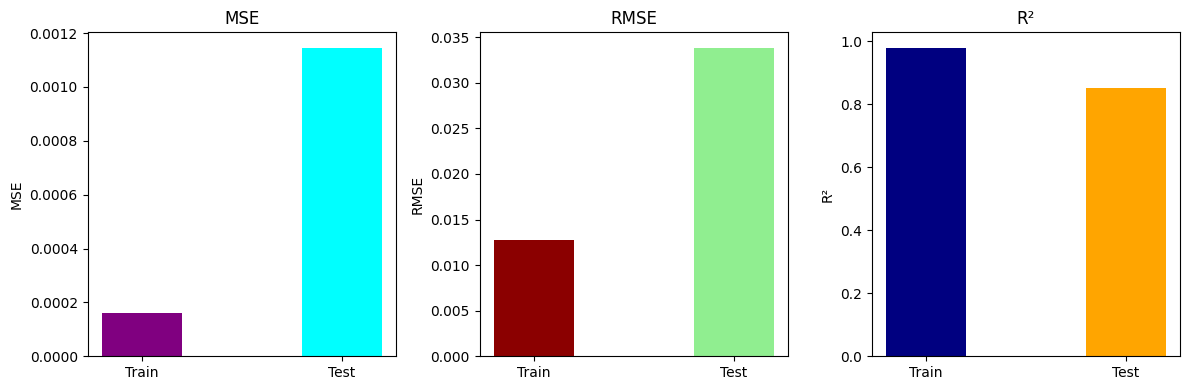

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# New performance metrics
training_scores = [mse_train, rmse_train, r2_train]
test_scores = [mse_test, rmse_test, r2_test]

# Set the figure size
plt.figure(figsize=(12, 4))

# Plotting MSE
plt.subplot(1, 3, 1)
bar_width = 0.4
index = np.arange(2)
plt.bar(index, [training_scores[0], test_scores[0]], bar_width, color=['purple', 'cyan'])
plt.xticks(index, ['Train', 'Test'])
plt.title('MSE')
plt.ylabel('MSE')

# Plotting RMSE
plt.subplot(1, 3, 2)
plt.bar(index, [training_scores[1], test_scores[1]], bar_width, color=['darkred', 'lightgreen'])
plt.xticks(index, ['Train', 'Test'])
plt.title('RMSE')
plt.ylabel('RMSE')

# Plotting R²
plt.subplot(1, 3, 3)
plt.bar(index, [training_scores[2], test_scores[2]], bar_width, color=['navy', 'orange'])
plt.xticks(index, ['Train', 'Test'])
plt.title('R²')
plt.ylabel('R²')

plt.tight_layout()
plt.show()


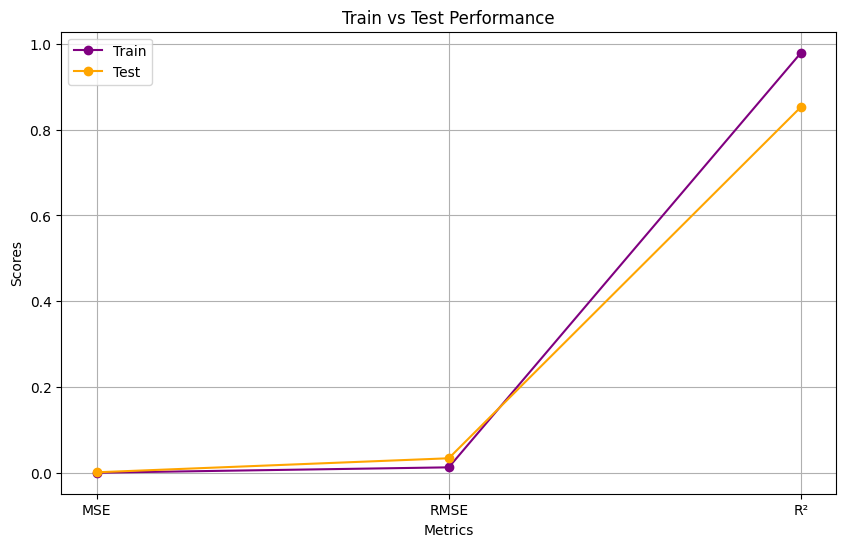

In [ ]:
# Data for plotting
metrics = ['MSE', 'RMSE', 'R²']
train_scores = [mse_train, rmse_train, r2_train]
test_scores = [mse_test, rmse_test, r2_test]

plt.figure(figsize=(10, 6))

plt.plot(metrics, train_scores, marker='o', label='Train', color='purple')
plt.plot(metrics, test_scores, marker='o', label='Test', color='orange')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Train vs Test Performance')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Generate predictions
y_pred = best_model.predict(X_test)



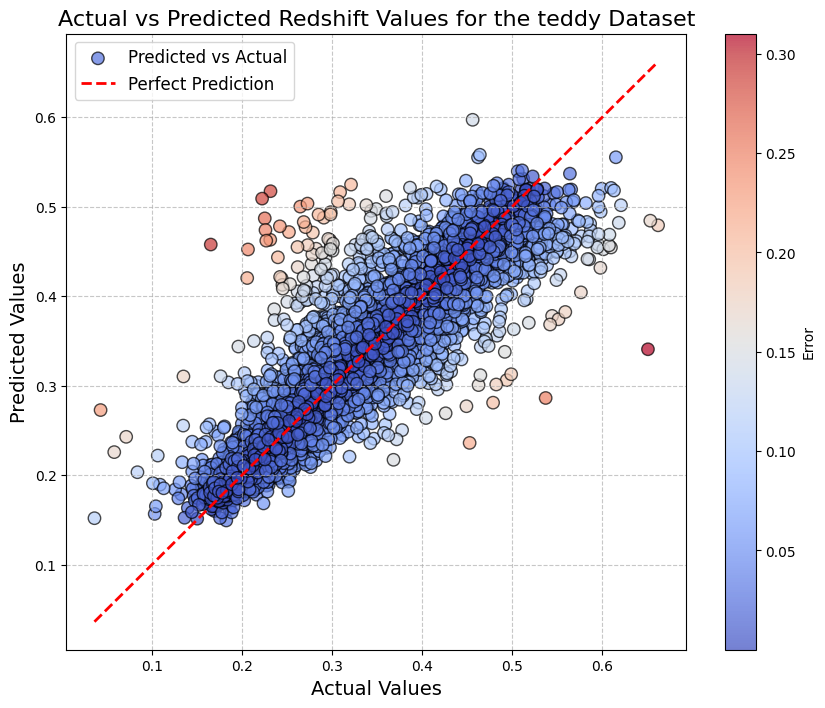

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test and y_pred are pandas Series
# Example: y_test = pd.Series([...]), y_pred = pd.Series([...])

# Calculate error
errors = np.abs(y_test - y_pred)

# Create a scatter plot with a color gradient based on the error
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, c=errors, cmap='coolwarm', alpha=0.7, edgecolor='k', s=80, label='Predicted vs Actual')

# Add a line for the perfect prediction
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, linestyle='--', label='Perfect Prediction')

# Customize the plot
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.title('Actual vs Predicted Redshift Values for the teddy Dataset', fontsize=16)
plt.legend(fontsize=12)
plt.colorbar(label='Error')
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()
